## Modeling

### Model 0

#### Model Definition:

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=4000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [5]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(os.path.join(path, model_name)):
        os.makedirs(os.path.join(path, model_name))
    fname = os.path.join(path, model_name, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Graph of Model:
![title](logs/models/model_0/model_0.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=3000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init=0):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64)
             }
    
    features = tf.keras.layers.Concatenate()([inputs[fname] for fname in inputs.keys() if '8-k' not in fname])
    
    output_wfc = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, name='adjusted_close_target_WFC')(features)
    #output_jpm = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, name='log_adj_daily_returns_target_JPM')(features)
    #output_bac = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, name='log_adj_daily_returns_target_BAC')(features)
    #output_c = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, name='log_adj_daily_returns_target_C')(features)
    
    outputs = {
               'adjusted_close_target_WFC': output_wfc, 
              }
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0, baseline_model, batch_size=4, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if 'adjusted_close' in feature_name:
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif '8-k' in feature_name:
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on null features.

In [7]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

epochs = 10
batch_size = 4
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 16 samples
Epoch 1/10
16/16 [==============================] - 17s 1s/sample - loss: 385.3904
Epoch 2/10
16/16 [==============================] - 12s 750ms/sample - loss: 294.7742
Epoch 3/10
16/16 [==============================] - 12s 751ms/sample - loss: 244.9124
Epoch 4/10
16/16 [==============================] - 12s 735ms/sample - loss: 214.6178
Epoch 5/10
16/16 [==============================] - 12s 728ms/sample - loss: 198.9521
Epoch 6/10
16/16 [==============================] - 12s 725ms/sample - loss: 191.5750
Epoch 7/10
16/16 [==============================] - 12s 726ms/sample - loss: 186.8328
Epoch 8/10
16/16 [==============================] - 12s 721ms/sample - loss: 183.2223
Epoch 9/10
16/16 [==============================] - 12s 731ms/sample - loss: 179.5221
Epoch 10/10
16/16 [==============================] - 12s 733ms/sample - loss: 176.0314


The memory issue is weird because I'll reset the kernel (which kills the python process reseting the GPU memory), run the same code, and have the GPU run out of memory about 80% of the time I rerun the same code. The longer I wait between sessions using the GPU, the more likely I won't encounter the issue. *Suprisingly when I train on smaller datasets I encounter the error usually in the first batch, but when I train on larger datasets, it usually doesnt show up in the first batch.* When the error is not raised in the first batch, the batch number it shows up in varies from run to run even when I have all possible random number generators seeded and am using the same dataset. When seeding all possible random number generators running without the GPU, I get reproducible metrics, and the training never crashes, but when introducing the GPU I introduce this memory error. It appears to me that the problem lies with the GPU, since my since my code trains perfectly well on the CPU and produces reproducible results. Hypothesis: Maybe the amount of memory the GPU needs to allocate to perform calculations for my code differs from run to run even when the calculation performed is still the mathematically the same (or very similar). ie run 1: 2+2 requires 1 byte to compute, run 2: 2+2 requires 3.5 bytes to compute. IDK.
When I do successfully train the model on GPU I get the same metrics I get when training on the CPU

Evaluating model.

In [8]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [9]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 411.3193817138672



###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on actual data.

In [4]:
#X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X, y = train_dataset
X_val, y_val = val_dataset

epochs = 100
batch_size = 2
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 3014 samples, validate on 1001 samples
Epoch 1/100
 226/3014 [=>............................] - ETA: 1:08:55 - loss: 248.2337

KeyboardInterrupt: 

Evaluating model.

In [ ]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [ ]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))

Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [16]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        print(list(range(len(true_labels.keys()))))
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Overtraining model on a small sample of the data.

In [18]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    print(m_pred_untrained.shape)
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns_WFC')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data
(2, 1)
[0, 1, 2, 3]


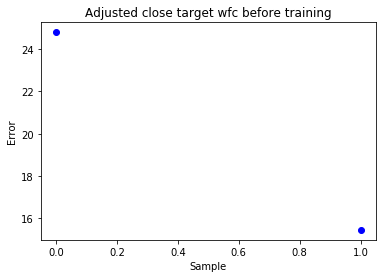

[0, 1, 2, 3]


IndexError: index 1 is out of bounds for axis 1 with size 1

In [19]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
overfit_small_sample(model_0, batch_size=1, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)

# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [ ]:
def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

***

In [6]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_1(lstm_layer_units_0=64, lstm_layer_units_1=32, lstm_layer_units_2=16, vocab=vocab, 
            doc_embedding_size=100, output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm_0 = tf.keras.layers.LSTM(lstm_layer_units_0, return_sequences=True)(time_series_input)
    time_series_lstm_0 = tf.keras.layers.Dropout(0.2)(time_series_lstm_0)
    time_series_lstm_1 = tf.keras.layers.LSTM(lstm_layer_units_1, return_sequences=True)(time_series_lstm_0)
    time_series_lstm_1 = tf.keras.layers.Dropout(0.2)(time_series_lstm_1)
    time_series_lstm_2 = tf.keras.layers.LSTM(lstm_layer_units_2)(time_series_lstm_1)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm_2)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Splitting train dataset into train and validation dataset.

In [5]:
'''X_train, y_train = train_dataset
X_val, y_val = val_dataset

print('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))
print('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))'''

"X_train, y_train = train_dataset\nX_val, y_val = val_dataset\n\nprint('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))\nprint('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))"

Building model.

In [6]:
# Defining and Saving Hyperparameters
#LOSS = tf.keras.losses.MeanSquaredError()
#OPTIMIZER = tf.keras.optimizers.Adam()
#model_params = {'lstm_layer_units': 32, 'vocab': vocab, 'doc_embedding_size': 100, 'output_bias_init': 0}
training_params = {'batch_size': 2, 'epochs': 12}
#model_version = 0
#hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
#                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
#write_hparams('model_0', hyperparameters)

# Defining Metrics
#METRICS = []

# Setting unique Run Number 
#run_number = 0

In [7]:
#output_bias_init = 0
#hparams = {'output_bias_init': output_bias_init}
#model = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

Training model.

In [8]:
'''# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_0',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0'''

X, y = train_dataset
X_val, y_val = val_dataset

epochs = 18
batch_size = 6
output_bias_init = y['adjusted_close_target_WFC'].mean()
hparams = {'output_bias_init': output_bias_init, 'lstm_layer_units': 32}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 3014 samples, validate on 1001 samples
Epoch 1/18
  30/3014 [..............................] - ETA: 1:00:26 - loss: 17.9536

KeyboardInterrupt: 

Evaluating model.

In [8]:
# Gathering Data

#TODO: CALCULATE TREND ACCURACY METRIC
metrics_train = m.evaluate(X, y, batch_size=batch_size, verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
m_preds_train = m.predict(X, batch_size=batch_size)
m_preds_val = m.predict(X_val, batch_size=batch_size)
m_preds_up_train = ((m_preds_train[1:, 0] - y['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
m_preds_up_val = ((m_preds_val[1:, 0] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_train = ((y['adjusted_close_target_WFC'][1:] - y['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_val = ((y_val['adjusted_close_target_WFC'][1:] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


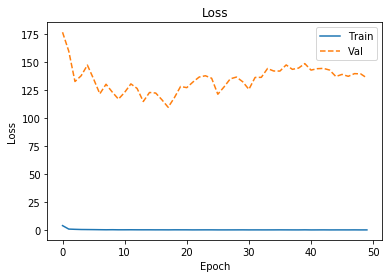

Loss on train dataset: 0.2743346627187367
Loss on validation dataset: 135.92893173454047

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.976435446398938
Accuracy on validation dataset: 0.739


In [11]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

In [25]:
mask = ((m_preds_val[1:, 0] - y_val['adjusted_close_target_WFC'][:-1]) > 0)
returns = y_val['adjusted_close_target_WFC'][1:] - y_val['adjusted_close_target_WFC'][:-1]
sum(returns[mask]*(300000 / 20))
# bullshit

49615384.5

### Evaluating Selected Model

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
X_train, y_train = train_dataset
X_test, y_test = test_dataset

In [3]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        if history != None:
            plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [4]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Building model.

In [5]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 50}
model_version = 'final'
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_selected', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_selected/version_final


In [6]:
model = build_compiled_model(model_0, 'model_selected', hyperparameters, metrics=metrics, run_number=run_number)

Training model on full train dataset.

In [7]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_selected',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X_train, y_train, **training_parameters, validation_data=(X_test, y_test),
                          initial_epoch=initial_epoch, callbacks=callbacks)

Train on 7410 samples, validate on 2470 samples
Epoch 1/50
7410/7410 [==============================] - 402s 54ms/sample - loss: 0.0014 - val_loss: 7.1876e-04
Epoch 2/50
7410/7410 [==============================] - 405s 55ms/sample - loss: 8.5110e-04 - val_loss: 6.8347e-04
Epoch 3/50
7410/7410 [==============================] - 412s 56ms/sample - loss: 8.2944e-04 - val_loss: 6.7151e-04
Epoch 4/50
7410/7410 [==============================] - 407s 55ms/sample - loss: 8.0630e-04 - val_loss: 7.0192e-04
Epoch 5/50
7410/7410 [==============================] - 416s 56ms/sample - loss: 8.0736e-04 - val_loss: 6.6922e-04
Epoch 6/50
7410/7410 [==============================] - 411s 56ms/sample - loss: 7.9791e-04 - val_loss: 6.6630e-04
Epoch 7/50
7410/7410 [==============================] - 422s 57ms/sample - loss: 8.0261e-04 - val_loss: 6.7528e-04
Epoch 8/50
7410/7410 [==============================] - 413s 56ms/sample - loss: 8.1416e-04 - val_loss: 6.8368e-04
Epoch 9/50
7410/7410 [==============

Evaluating model on test dataset.

In [9]:
# Gathering Data
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

Learning Curves for Metrics:


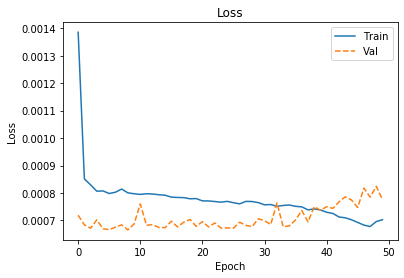

Loss on train dataset: 0.0006485506063616562
Loss on validation dataset: 0.0007747489441738396

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.5464237516869096
Accuracy on validation dataset: 0.5040485829959515


In [13]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(model_history, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

In [6]:
hparam_version = hyperparameters['version']
loss = hyperparameters['loss']
optimizer = hyperparameters['optimizer']
model_parameters = hyperparameters['model_parameters']
model = model_0(**model_parameters)
path_to_ckpt = os.path.join('logs', 'models', 'model_selected', '_'.join(['version', str(hparam_version)]),
                            'runs', str(run_number), 'checkpoints')
ckpt = os.path.join(path_to_ckpt, 'cp-30.ckpt')
model.load_weights(ckpt)
print('Restored model from: {}'.format(ckpt))  
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Restored model from: logs/models/model_selected/version_final/runs/0/checkpoints/cp-30.ckpt


In [7]:
# Gathering Data
training_parameters = hyperparameters['training_parameters']
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

In [8]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(None, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

Learning Curves for Metrics:
Loss on train dataset: 0.000738731865831522
Loss on validation dataset: 0.0007058223036158149

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.525910931174089
Accuracy on validation dataset: 0.5101214574898786


## Training and Saving Model for Deployment

Restart kernel to clear GPU memory

In [5]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    X, y = pickle.load(f)
    
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [6]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        if history != None:
            plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Building model.

In [4]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 30}
model_version = 'final'
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_deployment', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_deployment/version_final


In [6]:
model = build_compiled_model(model_0, 'model_deployment', hyperparameters, metrics=metrics, run_number=run_number)

AttributeError: 'NoneType' object has no attribute 'endswith'

Training model on full train dataset.

In [6]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_deployment',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=2)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X, y, **training_parameters, validation_data=(X_test, y_test),
                          initial_epoch=initial_epoch, callbacks=callbacks)

NameError: name 'X_train' is not defined

Evaluating model on test dataset.

In [9]:
# Gathering Data
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

Learning Curves for Metrics:


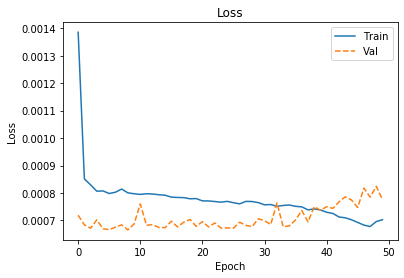

Loss on train dataset: 0.0006485506063616562
Loss on validation dataset: 0.0007747489441738396

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.5464237516869096
Accuracy on validation dataset: 0.5040485829959515


In [13]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(model_history, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

Saving model for deployment.

In [5]:
m.save(os.path.join(path_to_models, 'model_0'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /media/Data/Programs/FinTech/models/model_0/assets


# BLAH OLD CODE TO REVIST

### Model 0

#### Model Definition:

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


FileNotFoundError: [Errno 2] No such file or directory: '/media/Data/Programs/FinTech/data/dataset.pickle'

In [1]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(path):
        os.makedirs(path)
    fname = os.path.join(path, model_name, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [12]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

gen_print_model_stats(model_0, os.path.join('logs', 'models'), 'model_0')

Model: "model_0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
docs (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
document_embedder (Model)       (None, 100)          2911400     docs[0][0]                       
__________________________________________________________________________________________________
log_adj_daily_returns (InputLay [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 100)       0           document_embedder[1][0]          
____________________________________________________________________________________________

Graph of Model:
![title](logs/models/model_0/model_0.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(inputs['log_adj_daily_returns'])}
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0, baseline_model, batch_size=8, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Turns On and Off the GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if (feature_name == 'log_adj_daily_returns'):
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif (feature_name == 'docs'):
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on null features.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

epochs = 100
batch_size = 4
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 17s 1s/sample - loss: 0.1680
Epoch 2/100
16/16 [==============================] - 11s 663ms/sample - loss: 0.0705
Epoch 3/100
16/16 [==============================] - 11s 662ms/sample - loss: 0.0228
Epoch 4/100
16/16 [==============================] - 11s 659ms/sample - loss: 0.0074
Epoch 5/100
16/16 [==============================] - 11s 679ms/sample - loss: 0.0069
Epoch 6/100
16/16 [==============================] - 11s 681ms/sample - loss: 0.0049
Epoch 7/100
16/16 [==============================] - 11s 662ms/sample - loss: 0.0013
Epoch 8/100
16/16 [==============================] - 11s 665ms/sample - loss: 0.0032
Epoch 9/100
16/16 [==============================] - 11s 662ms/sample - loss: 5.0525e-04
Epoch 10/100
16/16 [==============================] - 11s 660ms/sample - loss: 0.0012
Epoch 11/100
16/16 [==============================] - 11s 658ms/sample - loss: 6.2191e-04
Epoch 12/100
16/16 [==================

The memory issue is weird because I'll reset the kernel (which kills the python process reseting the GPU memory), run the same code, and have the GPU run out of memory about 80% of the time I rerun the same code. The longer I wait between sessions using the GPU, the more likely I won't encounter the issue. *Suprisingly when I train on smaller datasets I encounter the error usually in the first batch, but when I train on larger datasets, it usually doesnt show up in the first batch.* When the error is not raised in the first batch, the batch number it shows up in varies from run to run even when I have all possible random number generators seeded and am using the same dataset. When seeding all possible random number generators running without the GPU, I get reproducible metrics, and the training never crashes, but when introducing the GPU I introduce this memory error. It appears to me that the problem lies with the GPU, since my since my code trains perfectly well on the CPU and produces reproducible results. Hypothesis: Maybe the amount of memory the GPU needs to allocate to perform calculations for my code differs from run to run even when the calculation performed is still the mathematically the same (or very similar). ie run 1: 2+2 requires 1 byte to compute, run 2: 2+2 requires 3.5 bytes to compute. IDK.
When I do successfully train the model on GPU I get the same metrics I get when training on the CPU

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 0.005705256695364369



###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on actual data.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)

epochs = 100
batch_size = 4
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}

m = build_compiled_model(model_0, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 6s 403ms/sample - loss: 0.0218
Epoch 2/100
16/16 [==============================] - 1s 38ms/sample - loss: 0.0342
Epoch 3/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0128
Epoch 4/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0099
Epoch 5/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0036
Epoch 6/100
16/16 [==============================] - 1s 35ms/sample - loss: 0.0048
Epoch 7/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0021
Epoch 8/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0021
Epoch 9/100
16/16 [==============================] - 1s 36ms/sample - loss: 0.0012
Epoch 10/100
16/16 [==============================] - 1s 35ms/sample - loss: 5.5630e-04
Epoch 11/100
16/16 [==============================] - 1s 35ms/sample - loss: 9.6478e-05
Epoch 12/100
16/16 [==============================] - 1s

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on actual data.

Loss for Model: 4.721949103725365e-06


Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data

Plotting Error against Sample for Before Training, and After Training on the Small Dataset


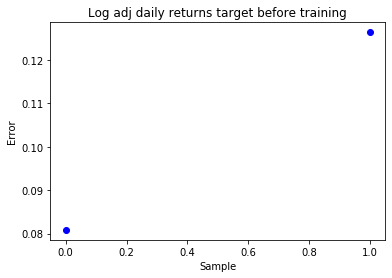

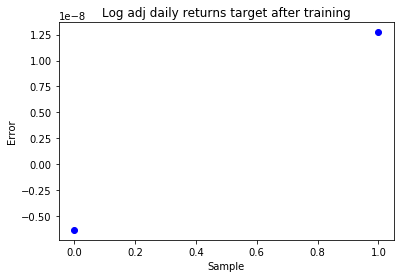


Plotting Each Sample's Time Series for Log Adjusted Daily Returns


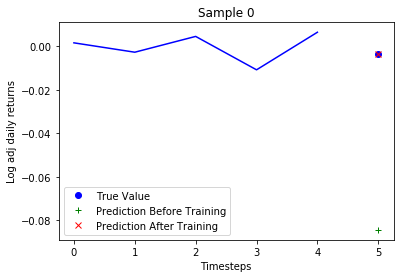

True Target Value: -0.0035051436379571754
Predicted Target Value Before Training: -0.08434920012950897
Predicted Target Value After Training: -0.0035051372833549976




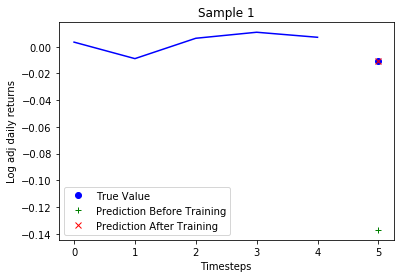

True Target Value: -0.010760221939794423
Predicted Target Value Before Training: -0.13711243867874146
Predicted Target Value After Training: -0.010760234668850899




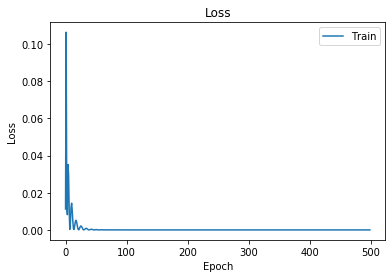

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
overfit_small_sample(model_0, batch_size=2, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f) 
     
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Splitting train dataset into train and validation dataset.

In [4]:
train, val = split_dataset(train_dataset, train_size=0.75, random_state=seed)
X_train, y_train = train
X_val, y_val = val

print('Train set size: {}'.format(len(y_train['log_adj_daily_returns_target'])))
print('Validation set size: {}'.format(len(y_val['log_adj_daily_returns_target'])))
print('Test set size: {}'.format(len(test_dataset[1]['log_adj_daily_returns_target'])))

Train set size: 5557
Validation set size: 1853
Test set size: 2470


Building model.

In [5]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 1500}
model_version = 0
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_0', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_0/version_0


In [6]:
model = build_compiled_model(model_0, 'model_0', hyperparameters, metrics=metrics, run_number=run_number)

Restored model from: logs/models/model_0/version_0/runs/0/checkpoints/cp-100.ckpt


Training model.

In [ ]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_0',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X_train, y_train, **training_parameters,
                          initial_epoch=initial_epoch, callbacks=callbacks) # validation_data=(X_val, y_val)

Train on 5557 samples
Epoch 100/1500
5557/5557 [==============================] - 252s 45ms/sample - loss: 3.6727e-04
Epoch 101/1500
5557/5557 [==============================] - 268s 48ms/sample - loss: 3.6627e-04
Epoch 102/1500
5557/5557 [==============================] - 261s 47ms/sample - loss: 3.6860e-04
Epoch 103/1500
5557/5557 [==============================] - 268s 48ms/sample - loss: 3.6345e-04
Epoch 104/1500
5557/5557 [==============================] - 252s 45ms/sample - loss: 3.6142e-04
Epoch 105/1500
5557/5557 [==============================] - 242s 44ms/sample - loss: 3.5262e-04
Epoch 106/1500
5557/5557 [==============================] - 242s 44ms/sample - loss: 3.5099e-04
Epoch 107/1500
5557/5557 [==============================] - 240s 43ms/sample - loss: 3.4022e-04
Epoch 108/1500
5557/5557 [==============================] - 243s 44ms/sample - loss: 3.4392e-04
Epoch 109/1500
5556/5557 [============================>.] - ETA: 0s - loss: 3.4236e-04
Epoch 00109: saving model t

Evaluating model.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = m.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_val = m.predict(X_val, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_val = (m_preds_val[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_val = y_val['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


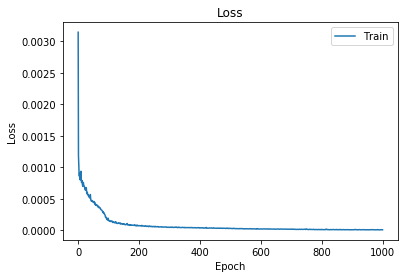

Loss on train dataset: 4.989523747099156e-06
Loss on validation dataset: 0.0013666351001578641

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.953


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
#print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

In [13]:
print(m_preds_train[:, 0] - y_train['log_adj_daily_returns_target'])

[ 1.13168225e-03  1.37693441e-03 -2.94649532e-03 -1.56740499e-04
  4.42081054e-05 -3.45404711e-04  5.36118984e-03  9.30834364e-04
  5.31926171e-04  1.44887850e-03 -2.47901282e-04 -3.65341622e-04
  3.56802002e-04  7.11967797e-04 -1.27560368e-03  8.37871121e-04
 -1.34503763e-04  2.69293435e-03  9.56341079e-04 -1.14950259e-03
  2.05272523e-03 -1.90569279e-04  1.02836398e-03  1.51925673e-04
 -2.43840400e-03  3.17201876e-04  2.14913129e-04  4.67219653e-03
 -6.07072954e-04  1.27161215e-03 -1.61569804e-04 -2.18755926e-03
  5.60527626e-04 -2.99900742e-04 -2.93392637e-03 -1.29017887e-03
  1.24451332e-03 -2.86464556e-03  2.10590779e-03  3.58878227e-04
 -6.47977049e-04  5.22670123e-04  4.18972464e-05  2.25678377e-04
  1.22242156e-03 -2.12826496e-03  5.77997468e-04 -8.84464393e-04
  6.23337677e-04  1.60486713e-04 -2.85154816e-03  1.06104919e-03
  2.38532897e-04  7.96082155e-03  2.11155502e-03 -5.39792498e-03
  7.89332936e-04  1.43231601e-04  7.30393749e-03 -1.41602025e-03
 -1.88576120e-03 -1.42429

### Evaluating Selected Model

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
X_train, y_train = train_dataset
X_test, y_test = test_dataset

In [3]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        if history != None:
            plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [4]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Building model.

In [5]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 50}
model_version = 'final'
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_selected', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_selected/version_final


In [6]:
model = build_compiled_model(model_0, 'model_selected', hyperparameters, metrics=metrics, run_number=run_number)

Training model on full train dataset.

In [7]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_selected',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=10)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X_train, y_train, **training_parameters, validation_data=(X_test, y_test),
                          initial_epoch=initial_epoch, callbacks=callbacks)

Train on 7410 samples, validate on 2470 samples
Epoch 1/50
7410/7410 [==============================] - 402s 54ms/sample - loss: 0.0014 - val_loss: 7.1876e-04
Epoch 2/50
7410/7410 [==============================] - 405s 55ms/sample - loss: 8.5110e-04 - val_loss: 6.8347e-04
Epoch 3/50
7410/7410 [==============================] - 412s 56ms/sample - loss: 8.2944e-04 - val_loss: 6.7151e-04
Epoch 4/50
7410/7410 [==============================] - 407s 55ms/sample - loss: 8.0630e-04 - val_loss: 7.0192e-04
Epoch 5/50
7410/7410 [==============================] - 416s 56ms/sample - loss: 8.0736e-04 - val_loss: 6.6922e-04
Epoch 6/50
7410/7410 [==============================] - 411s 56ms/sample - loss: 7.9791e-04 - val_loss: 6.6630e-04
Epoch 7/50
7410/7410 [==============================] - 422s 57ms/sample - loss: 8.0261e-04 - val_loss: 6.7528e-04
Epoch 8/50
7410/7410 [==============================] - 413s 56ms/sample - loss: 8.1416e-04 - val_loss: 6.8368e-04
Epoch 9/50
7410/7410 [==============

Evaluating model on test dataset.

In [9]:
# Gathering Data
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

Learning Curves for Metrics:


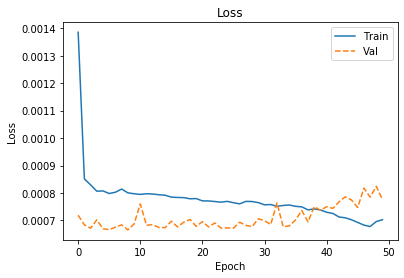

Loss on train dataset: 0.0006485506063616562
Loss on validation dataset: 0.0007747489441738396

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.5464237516869096
Accuracy on validation dataset: 0.5040485829959515


In [13]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(model_history, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

In [6]:
hparam_version = hyperparameters['version']
loss = hyperparameters['loss']
optimizer = hyperparameters['optimizer']
model_parameters = hyperparameters['model_parameters']
model = model_0(**model_parameters)
path_to_ckpt = os.path.join('logs', 'models', 'model_selected', '_'.join(['version', str(hparam_version)]),
                            'runs', str(run_number), 'checkpoints')
ckpt = os.path.join(path_to_ckpt, 'cp-30.ckpt')
model.load_weights(ckpt)
print('Restored model from: {}'.format(ckpt))  
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Restored model from: logs/models/model_selected/version_final/runs/0/checkpoints/cp-30.ckpt


In [7]:
# Gathering Data
training_parameters = hyperparameters['training_parameters']
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

In [8]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(None, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

Learning Curves for Metrics:
Loss on train dataset: 0.000738731865831522
Loss on validation dataset: 0.0007058223036158149

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.525910931174089
Accuracy on validation dataset: 0.5101214574898786


## Training and Saving Model for Deployment

Restart kernel to clear GPU memory

In [5]:
# Importing Libraries and Configuring virtual GPU

import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    X, y = pickle.load(f)
    
# Defining Helper Functions 
def write_hparams(model_name, hparams, verbose=True):
    version_number = hparams['version']
    path = os.path.join('logs', 'models', model_name, '_'.join(['version', str(version_number)]))
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'hparams.pickle'), 'wb') as f:
        pickle.dump(hparams, f)
    if verbose:
        return print('Saved hyperparameters to file: {}'.format(path))
    else:
        return None

def build_compiled_model(build_model, model_name, hparams, metrics, run_number):
    hparam_version = hparams['version']
    loss = hparams['loss']
    optimizer = hparams['optimizer']
    model_parameters = hparams['model_parameters']
    model = build_model(**model_parameters)
    path_to_ckpt = os.path.join('logs', 'models', model_name, '_'.join(['version', str(hparam_version)]),
                               'runs', str(run_number), 'checkpoints')
    if os.path.exists(path_to_ckpt):
        latest = tf.train.latest_checkpoint(path_to_ckpt)
        model.load_weights(latest)
        print('Restored model from: {}'.format(latest))  
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [6]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        if history != None:
            plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [3]:
def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab=vocab, doc_embedding_size=100):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100,
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
    
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    
    doc_embeddings = document_embedder_model(vocab, doc_embedding_size)(inputs['docs'])
    
    reshape_doc_embeddings = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))(doc_embeddings)
    reshape_price_features = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    time_series_input = tf.keras.layers.Concatenate()([reshape_doc_embeddings, reshape_price_features])
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Building model.

In [4]:
# Defining and Saving Hyperparameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
model_params = {'lstm_layer_units': 256, 'vocab': vocab, 'doc_embedding_size': 200, 'output_bias_init': 0}
training_params = {'batch_size': 4, 'epochs': 30}
model_version = 'final'
hyperparameters = {'model_parameters': model_params, 'training_parameters': training_params,
                   'loss': LOSS, 'optimizer': OPTIMIZER, 'version': model_version}
write_hparams('model_deployment', hyperparameters)

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Saved hyperparameters to file: logs/models/model_deployment/version_final


In [6]:
model = build_compiled_model(model_0, 'model_deployment', hyperparameters, metrics=metrics, run_number=run_number)

AttributeError: 'NoneType' object has no attribute 'endswith'

Training model on full train dataset.

In [6]:
# Setting up callbacks
path_to_run = os.path.join('logs', 'models', 'model_deployment',
                            '_'.join(['version', str(hyperparameters['version'])]),
                            'runs', str(run_number))
path_to_ckpts = os.path.join(path_to_run, 'checkpoints')
if not os.path.exists(path_to_ckpts):
    os.makedirs(path_to_ckpts)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_to_ckpts, 'cp-{epoch}.ckpt'),
                                                 verbose=1, save_weights_only=True, period=2)
csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(path_to_run, 'history.log'), append=True)
callbacks = [cp_callback, csv_logger]

# Unpacking model training parameters
training_parameters = hyperparameters['training_parameters']

# Fetching last trained epoch if the model was reloaded
latest_ckpt = tf.train.latest_checkpoint(path_to_ckpts)
if latest_ckpt is not None:
    initial_epoch = re.findall(r'cp-(\d+)\.ckpt', latest_ckpt)[0]
    initial_epoch = int(initial_epoch) - 1
else:
    initial_epoch = 0

model_history = model.fit(X, y, **training_parameters, validation_data=(X_test, y_test),
                          initial_epoch=initial_epoch, callbacks=callbacks)

NameError: name 'X_train' is not defined

Evaluating model on test dataset.

In [9]:
# Gathering Data
metrics_train = model.evaluate(X_train, y_train, batch_size=training_parameters['batch_size'], verbose=0)
metrics_test = model.evaluate(X_test, y_test, batch_size=training_parameters['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_parameters['batch_size'])
m_preds_test = model.predict(X_test, batch_size=training_parameters['batch_size'])
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_test = (m_preds_test[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_test = y_test['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_test = np.mean(np.equal(m_preds_up_test, labels_up_test))

Learning Curves for Metrics:


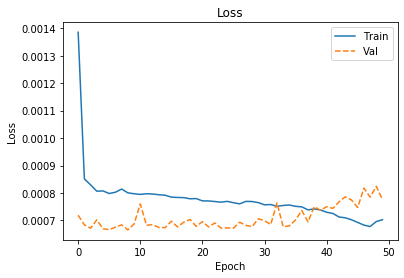

Loss on train dataset: 0.0006485506063616562
Loss on validation dataset: 0.0007747489441738396

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.5464237516869096
Accuracy on validation dataset: 0.5040485829959515


In [13]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(model_history, metrics_train=metrics_train, metrics_val=metrics_test, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_test))

Saving model for deployment.

In [5]:
m.save(os.path.join(path_to_models, 'model_0'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /media/Data/Programs/FinTech/models/model_0/assets
